want to roll a FWTD. Will stick a FWTD at both ends of a rigid beam that can rotate freely

### Preamble

In [1]:
import sympy as sym
import sympy.physics.mechanics as me
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef

me.mechanics_printing()

### Define the Model

#### Create Parameter instance

In [2]:
half = sym.Rational(1,2)

p = mf.ModelParameters.DynamicModel(3)

# fwt params
p.Lambda = mf.ModelVariable(np.deg2rad(10),'Lambda') # flare angle
p.y_f = sym.Symbol('y_f')# spanwise location
p.alpha_0 = mf.ModelVariable(0,'alpha_0')
    
# Attitude Parmas
p.rho = mf.ModelVariable(1.225,'rho') # density
p.V = mf.ModelVariable(10,'V') # velocity
p.g  = mf.ModelVariable(9.81,'g') # gravity
p.alpha_r = mf.ModelVariable(np.deg2rad(3),'alpha_r') # root AoA

# Main Wing Parameter
p.a_w = mf.ModelVariable(2*np.pi,'a_w') # C_L of wing
p.y_w = sym.Symbol('y_w') # spanwise location


# Create some global parameters
p.c = mf.ModelVariable(0.067,'c') # chord of wing
#p.m_t = mf.ModelVariable(2,'m_t') # wing total mass
p.s_t = mf.ModelVariable(1,'s_t') # wing total span
p.sigma = mf.ModelVariable(7/25,'sigma') # FWT as percentage of total span
#p.f = mf.ModelVariable(2,'f') # initial freqency


# Set dependent expressions
p.m_w = mf.ModelVariable(0.22,'m_w') # density # mass of inner wing
p.s_w = p.s_t*(sym.Integer(1)-p.sigma) # span of main wing
p.m_f = mf.ModelVariable(0.038,'m_f') # mass of each FWT
p.s_f = p.s_t*p.sigma*half # span of each FWT

#p.a_f_0 = mf.ModelVariable(np.pi*2,'a_f0')
#p.a_f_grad = mf.ModelVariable((2*np.pi)/1*0.2*0.5,'a_f_grad')
p.a_f = 2*sym.pi - 2*sym.pi/p.s_f*p.y_f #p.a_f_0 - p.a_f_grad*p.y_f


p.I_xx_f = sym.Rational(1,12)*p.m_f*p.s_f**2 # inertia of FWT (uniform bar)
p.I_xx_w = sym.Rational(1,12)*p.m_w*p.s_w**2 # inertia of wing (uniform bar)
p.l_f = p.s_f*half # location of FWT CoM from Hinge
p.l_w = 0 # location of main wing CoM

p.aoa_rhs = mf.ModelVariable(0,'alpha_rhs') # chord of wing
p.aoa_lhs = mf.ModelVariable(0,'alpha_lhs') # chord of wing

# Locking mechanism
p.m_l = mf.ModelVariable(0.0275,'m_w') # density # mass of inner wing

#### Create Transforms

system has 3 degrees of freedom:

q[0] - rotation about the base of the spring (roll)
q[1] - plunging motion
q[2] - FWT fold angle



In [3]:
wing_frame = mf.HomogenousTransform().R_x(p.q[0]).R_y(p.alpha_r)
rhs_fwt_frame = wing_frame.Translate(0,p.s_w*half,0).R_x(-p.q[1])  # RHS Fwt Frame
lhs_fwt_frame = wing_frame.Translate(0,-p.s_w*half,0).R_x(p.q[2])  # RHS Fwt Frame

M_fwt = ele.MassMatrix(p.m_f,I_xx = p.I_xx_f)
M_w = ele.MassMatrix(p.m_w,I_xx = p.I_xx_w)
M_lock = ele.MassMatrix(p.m_l)

bar_fwt_rhs = ele.RigidElement(rhs_fwt_frame.Translate(0,p.l_f,0),M_fwt,True)
bar_fwt_lhs = ele.RigidElement(lhs_fwt_frame.Translate(0,-p.l_f,0),M_fwt,True)
bar_wing = ele.RigidElement(wing_frame,M_w)
rhs_lock = ele.RigidElement(rhs_fwt_frame,M_lock,True)
lhs_lock = ele.RigidElement(lhs_fwt_frame,M_lock,True)

# Gravitational Forces
#fwt_GravityForces_rhs = ef.GravityForce(p,rhs_fwt_frame.Translate(0,p.l_f,0),sym.Matrix([0,0,-p.g*p.m_f]))
#fwt_GravityForces_lhs = ef.GravityForce(p,lhs_fwt_frame.Translate(0,-p.l_f,0),sym.Matrix([0,0,-p.g*p.m_f]))
#wing_GravityForces = ef.GravityForce(p,wing_frame,sym.Matrix([0,0,-p.g*p.m_w]))
#Aero Forces
rhs_fwt_AeroForces = ef.AeroForce(p,rhs_fwt_frame.Translate(0,p.y_f,0),p.a_f,(p.y_f,0,p.s_f),0,0,0,p.aoa_rhs,0,p.alpha_0)
lhs_fwt_AeroForces = ef.AeroForce(p,lhs_fwt_frame.Translate(0,-p.y_f,0),p.a_f,(p.y_f,0,p.s_f),0,0,0,p.aoa_lhs,0,p.alpha_0)

In [4]:
wing_frame_aero = wing_frame.Translate(0,p.y_w,0)
wing_AeroForces = ef.AeroForce(p,wing_frame_aero,p.a_w,(p.y_w,-p.s_w*half,p.s_w*half),0,0,0,p.alpha_r,0)


Forcing = ef.CustomForce(p,None) 

CompositeForce = ef.CompositeForce(p,[rhs_fwt_AeroForces,lhs_fwt_AeroForces,wing_AeroForces,Forcing])

In [5]:
# create instance of the model
sm = mf.SymbolicModel.FromElementsAndForces(p,[rhs_lock,lhs_lock,bar_fwt_rhs,bar_fwt_lhs,bar_wing],ExtForces = CompositeForce)

In [108]:
# get fxed point conditions
p.V.value = 20
p.alpha_r.value = np.deg2rad(0)
p.alpha_0.value = 0.0
rhs_aoa = sym.lambdify((p.alpha_r,p.x),mf.GetAoA(p.alpha_r,0,p.Lambda.value,p.q[1]))
lhs_aoa = sym.lambdify((p.alpha_r,p.x),mf.GetAoA(p.alpha_r,0,p.Lambda.value,p.q[2]))

p.aoa_rhs.value = lambda t,x:rhs_aoa(p.alpha_r.value,x)
p.aoa_lhs.value = lambda t,x:lhs_aoa(p.alpha_r.value,x)

$\alpha_{fwt}=atan(sin(\Lambda)sin(\theta))+cos(\theta)\alpha_r$

# Find the required zero alpha on the fwt to level them at 17.5m/s 

In [255]:
p.V.value = 17.5

# need to set this to not zero!
def Force(tup,x,t):
    return np.zeros((int(len(x)/2),1))
Forcing.q_func = Force

# creaet objective function to minimise accel + velocity in the horizontal condition
from scipy.optimize import minimize
def ObjectiveFunc(alpha_0,t,tup):
    yv = [0,0,0,0,0,0]
    p.alpha_0.value = alpha_0[0]
    res = sm.deriv(t,yv,p.GetNumericTuple(yv,0))
    return sum((i**2 for i in res))

res = minimize(ObjectiveFunc,[0],(0,tup))
p.alpha_0.value = res.x[0]
np.rad2deg(res.x)[0]

# Get an equation at a constant roll rate (locked FWT's)

In [372]:
# All accelerations are equal to zero hence M*p.qdd must be zero, reducng the EoM!

# as FWT is locked
p.aoa_lhs.value = p.alpha_r.value
p.aoa_rhs.value = p.alpha_r.value

# sub in all but velocity & local AoA's
sm_sub = sm.subs(p,p.GetSubs(ignore=[p.V]))
F = sym.Symbol('F')
c_0 = sym.Symbol('c_0')
eom =sm_sub.f+sm_sub.ExtForces.Q() + sym.Matrix([F*p.V**2+c_0,0,0])

#FWT is locked + add the 
eom = eom.subs({p.q[1]:0,p.q[2]:0})[0]

s = sym.solveset(eom, symbol = F)
fun = sym.lambdify((p.qd[0],p.V,c_0),s.args[0])


# hunt for F that matchs 195 degrees per second at 20 m/s
c = -0.46
def obj(c):
    return ((fun(np.deg2rad(195),20,c[0])-fun(np.deg2rad(320),30,c[0]))*1000)**2
res = minimize(obj,[c])
res.x

obj([-0.16])

print(f'F = {fun(np.deg2rad(195),20,res.x[0])},  c = {res.x[0]}')
#sym.simplify(s.args[0])

F = 0.0027913634502497718,  c = -0.16160525230687517


## Get Equation for Roll rate of fixed case

In [373]:
s = sym.solveset(eom, symbol = p.qd[0])
fun = sym.lambdify((F,c_0),s.args[0])


# hunt for F that matchs 195 degrees per second at 20 m/s
sym.simplify(fun(0.00279,-0.162))
#sym.simplify(s.args[0])

## Get an equation for the removed case

In [377]:
CompositeForceRem = ef.CompositeForce(p,[wing_AeroForces,Forcing])
sm_rem = mf.SymbolicModel.FromElementsAndForces(p,[rhs_lock,lhs_lock,bar_wing],ExtForces = CompositeForceRem)
sm_rem_subs = sm_rem.subs(p,p.GetSubs(ignore=[p.V]))
eom =sm_rem_subs.f+sm_rem_subs.ExtForces.Q() + sym.Matrix([F*p.V**2+c_0,0,0])
eom = eom.subs({p.q[1]:0,p.q[2]:0})[0]
s = sym.solveset(eom, symbol = p.qd[0])
sym.simplify((s.args[0]).subs({F:0.00279,c_0:-0.162,sym.pi:np.pi}))

# Create Data For Free Case

In [530]:
sm_No_Aero = mf.SymbolicModel.FromElementsAndForces(p,[rhs_lock,lhs_lock,bar_fwt_rhs,bar_fwt_lhs,bar_wing],ExtForces = Forcing)



In [664]:
# get fxed point conditions
p.V.value = 25
p.Lambda.value = np.deg2rad(10)
p.alpha_r.value = np.deg2rad(0)
p.alpha_0.value = np.deg2rad(5.796)
rhs_aoa = sym.lambdify((p.alpha_r,p.x),mf.GetAoA(p.alpha_r,0,p.Lambda.value,p.q[1]))
lhs_aoa = sym.lambdify((p.alpha_r,p.x),mf.GetAoA(p.alpha_r,0,p.Lambda.value,p.q[2]))

p.aoa_rhs.value = lambda t,x:rhs_aoa(p.alpha_r.value,x)
p.aoa_lhs.value = lambda t,x:lhs_aoa(p.alpha_r.value,x)

# need to set this to not zero!
def Force(tup,x,t):
    #if t<5:
    #    return np.array([[0],[0],[0]])
    #else:
    return np.array([[0.00279*p.V.value**2-0.162],[-0.01*x[3]],[-0.01*x[5]]])
Forcing.q_func = Force

# find the 'steady' y0
# creaet objective function to minimise accel + velocity in the horizontal condition
from scipy.optimize import minimize
def ObjectiveFunc(aoa,t,tup):
    yv = [0,0,aoa[0],0,aoa[0],0]
    res = sm.deriv(t,yv,p.GetNumericTuple(yv,0))
    return sum((i**2 for i in res))

res = minimize(ObjectiveFunc,[0,0],(0,tup))

# set initial conditon from the steady case
y0 = [0,0,res.x[0],0,res.x[0],0]
y0 = [0,0,0.2,0,-1.2,0]
constraints = [np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN]
#constraints = [np.NaN,np.NaN,0,0,0,0]
#set-up numerical stuff
tmax, dt = 30, 0.01
ts = np.arange(0, tmax+dt, dt)
print(y0)
def objectiveDeriv(t,y):
    deriv = list(sm.deriv(t,y,p.GetNumericTuple(y,t)))
    return tuple(np.where(np.isnan(constraints),deriv,constraints))

[0, 0, 0.2, 0, -1.2, 0]


In [665]:
sm_No_Aero.deriv(0,[0]*6,p.GetNumericTuple([0]*6,0))

In [666]:
yData = solve_ivp(objectiveDeriv,(0,tmax),y0)

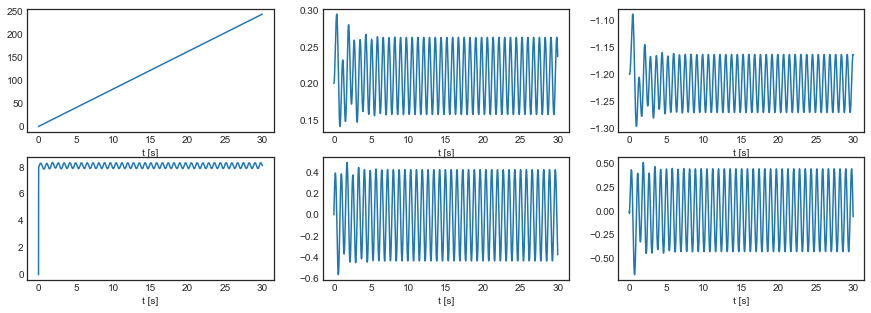

In [667]:
yi = yData.y
t = yData.t

plt.style.use('seaborn-white')

  
fig, axes = plt.subplots(2,int(len(yi)/2),figsize=(15,5))

for i in range(int(len(yi)/2)):
    # pos plot
    axes[0][i].plot(t,yi[i*2])
    axes[0][i].set_ylabel('')
    axes[0][i].set_xlabel('t [s]')
    
    # vel plot
    axes[1][i].plot(t,yi[i*2+1])
    axes[1][i].set_ylabel('')
    axes[1][i].set_xlabel('t [s]')

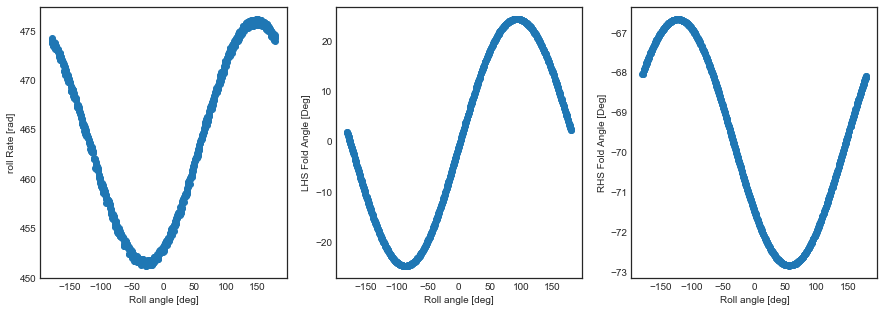

In [668]:
fig, axes = plt.subplots(1,3,figsize=(15,5))

# roll plot
ind = t>15
ydat = np.rad2deg(((yi[0][ind]+np.pi)%(2*np.pi))-np.pi)
axes[0].scatter(ydat,np.rad2deg(yi[1][ind]))
axes[0].set_ylabel('roll Rate [rad]')
axes[0].set_xlabel('Roll angle [deg]')

# d plot
axes[1].scatter(ydat,np.rad2deg(yi[3][ind]))
axes[1].set_ylabel('LHS Fold Angle [Deg]')
axes[1].set_xlabel('Roll angle [deg]')

# theta plot
axes[2].scatter(ydat,np.rad2deg(yi[4][ind]))
axes[2].set_ylabel('RHS Fold Angle [Deg]')
axes[2].set_xlabel('Roll angle [deg]')
np.mean(yi[1])

In [133]:
F = sym.Symbol('F')
roll_accel = (sm.M*p.qdd + sm.f + CompositeForce.Q() + sym.Matrix([F,0,0])).subs({p.q[2]:0,p.qd[1]:0,p.qd[2]:0,p.alpha_r:0})[0]

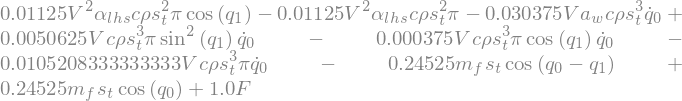

In [135]:
sym.simplify(roll_accel).subs({p.aoa_rhs:p.aoa_lhs,p.qdd[0]:0,p.sigma:0.1})